In [1]:
import sys
sys.path.append("../src")
from utils import *

In [2]:
adata = sc.read(os.path.join(datadir, "anca_samples_annotated_v2.h5ad"))

In [3]:
adata.obs.cluster_annot.value_counts()

PT                             2905
LOH                            1694
Inflamed tubulointerstitial    1407
PT/TAL                         1263
CNT/PC/IC                       973
Tubulointerstitial/Vessels      725
PT/DCT                          518
Normal glomerular               507
Inflamed glomerular             303
CNT/PC                          186
Tubulointerstitial              165
DCT/CNT                         117
Name: cluster_annot, dtype: int64

In [4]:
adata.obs["Sample"].unique()

['V5_A', 'V4_C', 'V5_C', 'V6_A', 'V3_C', ..., 'V3_D', 'V2_C', 'V3_A', 'V4_B', 'V5_D']
Length: 19
Categories (19, object): ['V1_A', 'V1_D', 'V2_B', 'V2_C', ..., 'V6_A', 'V6_B', 'V6_C', 'V6_D']

In [5]:
sc.set_figure_params(dpi=100)

In [6]:
sns.set(style="ticks", font_scale=1)

import matplotlib
from matplotlib import font_manager
font_dirs = "/usr/share/fonts/truetype/msttcorefonts/"
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

matplotlib.pyplot.rcParams['font.family'] = "arial"    

In [7]:
adata.obs["annot_v2"].value_counts()

Crescent     346
Normal       147
Uncertain     32
Name: annot_v2, dtype: int64

In [8]:
sub = adata[adata.obs["annot_v2"].isin(["Normal", "Crescent"])]
sub = sub.obs[["count_v2", "annot_v2", "cluster_annot_broad"]]

In [9]:
for count in sub.count_v2.unique():
    tmp = sub[sub["count_v2"]==count]
    
    if "Inflamed glomerular" in tmp["cluster_annot_broad"].tolist():
        idxs = tmp.index.tolist()
        sub.loc[idxs, "cluster_annot_broad"] = ["Inflamed glomerular"]*len(idxs)
        
    if "Normal glomerular" in tmp["cluster_annot_broad"].tolist() and \
        "Inflamed glomerular" not in tmp["cluster_annot_broad"].tolist() \
        and "Inflamed" not in tmp["cluster_annot_broad"].tolist():
        idxs = tmp[tmp["count_v2"]==count].index.tolist()
        sub.loc[idxs, "cluster_annot_broad"] = ["Normal glomerular"]*len(idxs)

In [10]:
for count in sub.count_v2.unique():
    tmp = sub[sub["count_v2"]==count]
    all_clst = tmp["cluster_annot_broad"].tolist()
    if "Normal glomerular" in all_clst and "Abnormal glomerular" in all_clst:
        print(count)

In [11]:
tab = pd.crosstab(sub["annot_v2"], sub["cluster_annot_broad"])
tab = tab.div(tab.sum(1),0)*100

row_order = ["Normal", "Crescent"]
col_order = ["Tubules", "Vasculature", "Tubulointerstitial", "Normal glomerular", "Inflamed glomerular", 
             "Inflamed tubulointerstitial"]

In [12]:
tab

cluster_annot_broad,Inflamed tubulointerstitial,Tubules,Normal glomerular,Tubulointerstitial/Vessels,Inflamed glomerular,Tubulointerstitial
annot_v2,,,,,,
Crescent,1.734104,2.890173,26.878613,4.046243,63.294798,1.156069
Normal,0.000000,0.000000,94.557823,0.000000,5.442177,0.000000


In [13]:
tab = pd.crosstab(sub["annot_v2"], sub["cluster_annot_broad"])
tab = tab.div(tab.sum(1),0)*100
tab.to_csv(os.path.join(datadir, "anca_samples_tab_image_gene.csv"))

In [14]:
for col in col_order:
    if col not in tab.columns:
        tab[col] = 0

In [15]:
import pickle
with open(os.path.join(datadir, "cluster_annot_broad_colors.pkl"), "rb") as f:
    colors_dict = pickle.load(f)

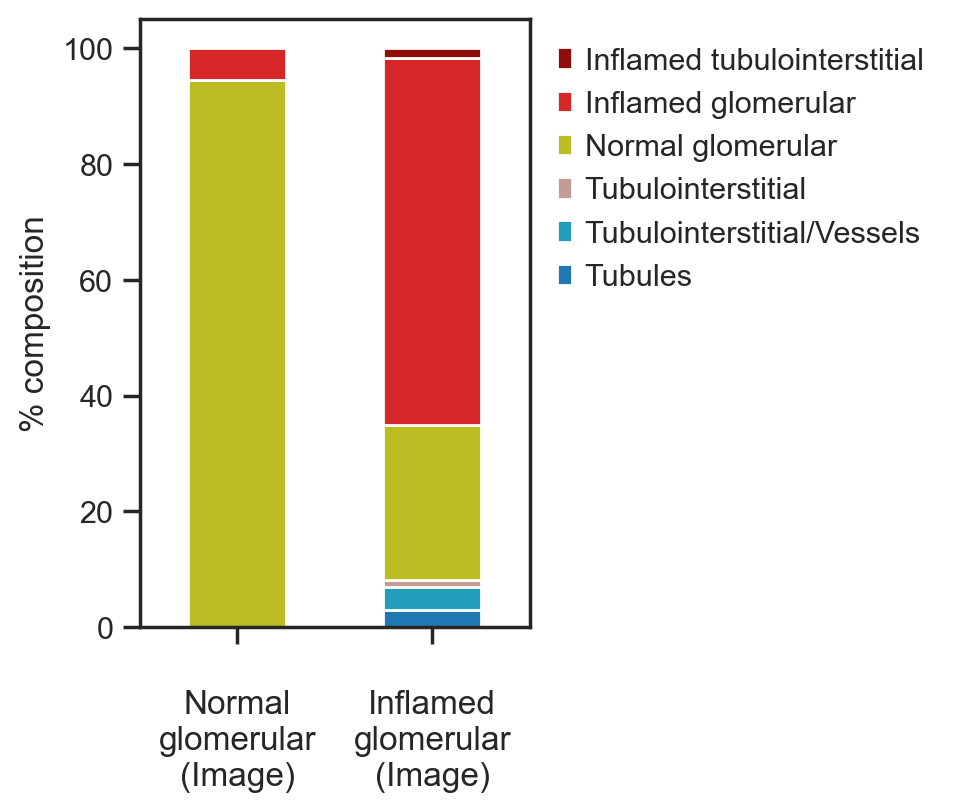

In [16]:
ax = tab.loc[row_order, col_order].plot(kind="bar", stacked=True, figsize=(2.5,4), color=colors_dict)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], bbox_to_anchor=(1,1), frameon=False)

ax.set_xlabel("")
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_ylabel("% composition")

ax.set_xticklabels(["\nNormal\nglomerular\n(Image)", "\nInflamed\nglomerular\n(Image)"], rotation=0, ha="center", fontsize=12)
plt.savefig(os.path.join(figdir, "BARPLOT_anca_samples_image_gene.pdf"), bbox_inches="tight")

# check Crescent/Normal glom.

In [17]:
idxs = []
for count in sub["count_v2"].unique():
    tmp = sub[sub["count_v2"]==count]
    if "Crescent" in tmp["annot_v2"].tolist() and "Inflamed glomerular" not in tmp["cluster_annot_broad"].tolist() \
        and "Normal glomerular" in tmp["cluster_annot_broad"].tolist():
        idxs = idxs + tmp.index.tolist()

In [18]:
tmp = adata.copy()

In [19]:
tmp.obs["cluster_annot_tmp"] = tmp.obs["cluster_annot_broad"].tolist()
tmp.obs.loc[idxs, "cluster_annot_tmp"] = ["Normal glomerular in gene\nbut crescent in image annotation"]*len(idxs)

In [20]:
tmp = tmp[tmp.obs["cluster_annot_tmp"].isin(["Normal glomerular", "Inflamed glomerular", 
                                             "Normal glomerular in gene\nbut crescent in image annotation"])]
tmp.obs["cluster_annot_tmp"] = tmp.obs["cluster_annot_tmp"].astype("category")

/tmp/ipykernel_15199/1635322847.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  tmp.obs["cluster_annot_tmp"] = tmp.obs["cluster_annot_tmp"].astype("category")


In [21]:
tmp.uns["cluster_annot_tmp_colors"] = ["red", "yellow", "black"]

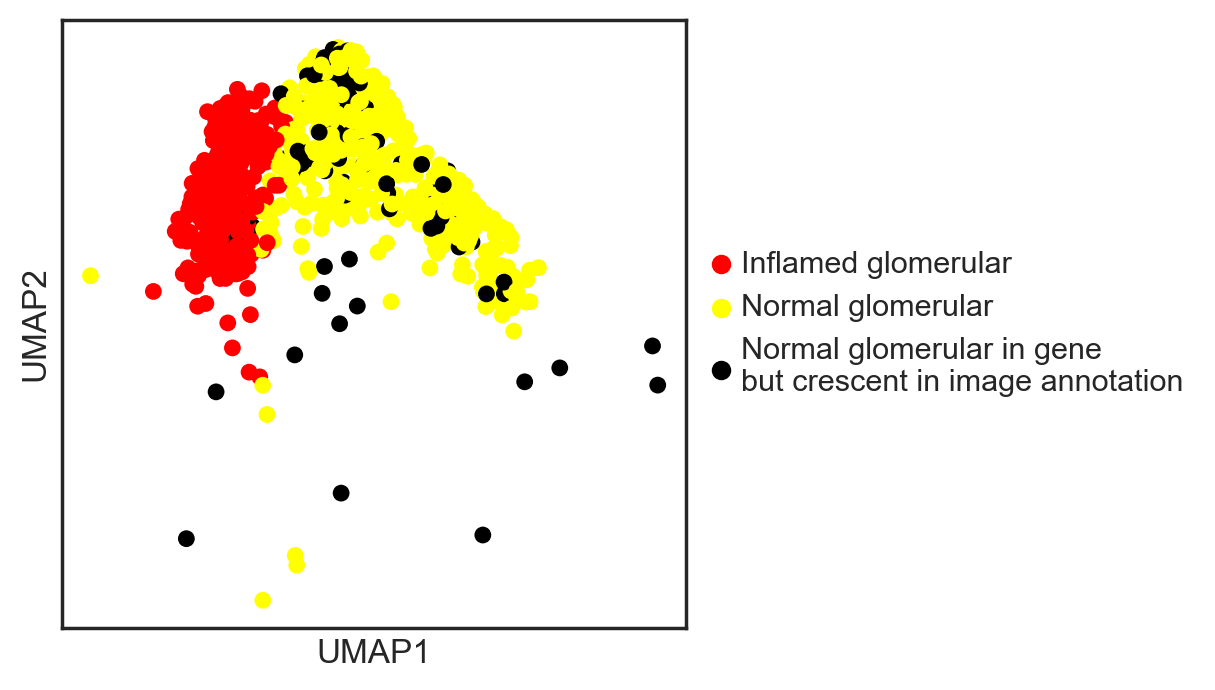

In [22]:
sc.pl.umap(tmp, color="cluster_annot_tmp", show=False, title="")
plt.savefig(os.path.join(figdir, "anca_samples_umap_diff_Normal_glomerular_Crescent.pdf"), bbox_inches="tight")

In [23]:
sc.pp.scale(tmp)

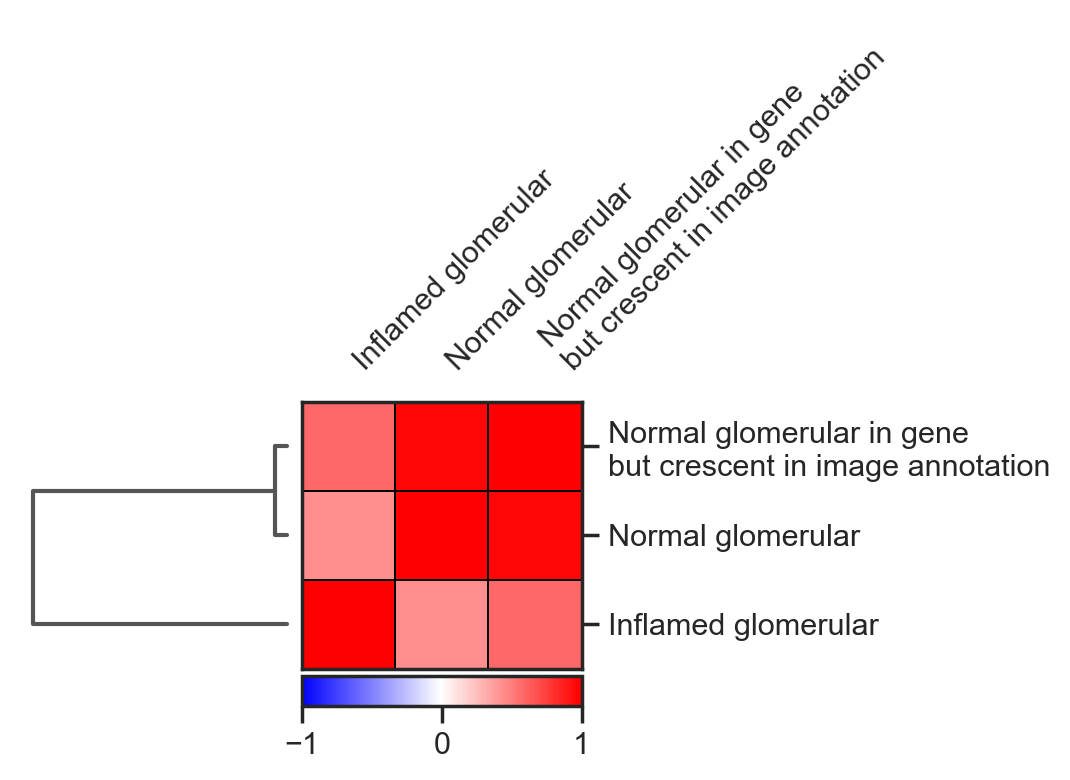

In [24]:
sc.pl.correlation_matrix(tmp, groupby="cluster_annot_tmp", show=False)
plt.savefig(os.path.join(figdir, "anca_samples_corr_image_gene.pdf"), bbox_inches="tight")

In [25]:
genes = ["PODXL", "WT1", "NPHS1", "NPHS2", "PTPRC", "CD14", "CD19", "CD3D", "CD4"]

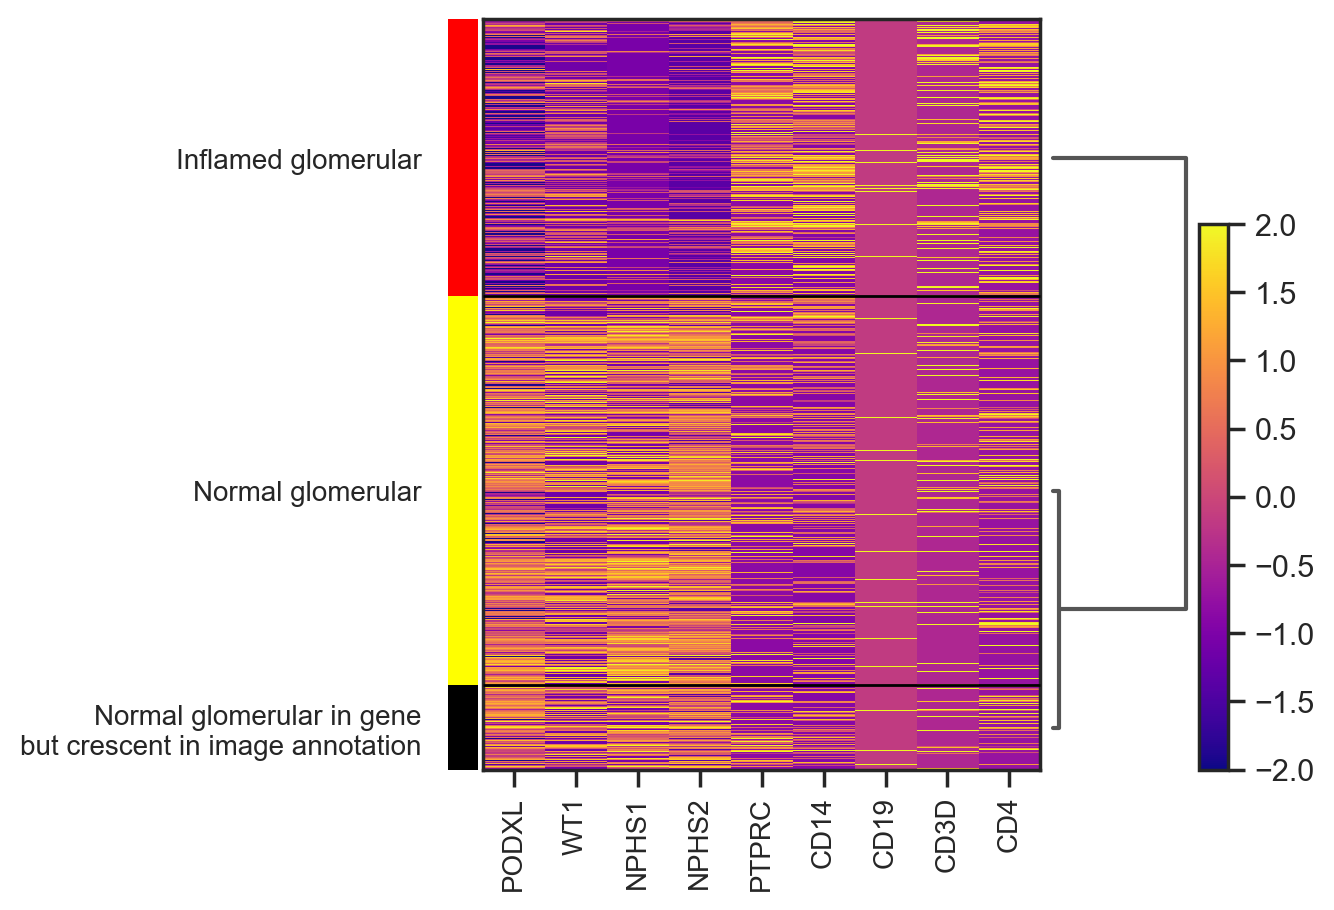

In [26]:
ax = sc.pl.heatmap(tmp, var_names=genes, groupby="cluster_annot_tmp", use_raw=False, vmin=-2, vmax=2, cmap="plasma", dendrogram=True,
             figsize=(5,5), show=False)
ax["groupby_ax"].set_ylabel("")
plt.savefig(os.path.join(figdir, "anca_samples_heatmap_genediff_Normal_glom._Crescent.pdf"), bbox_inches="tight")

In [27]:
sns.set(style="ticks", font_scale=1)
# plt.rcParams["font.family"] = ["Inter"]

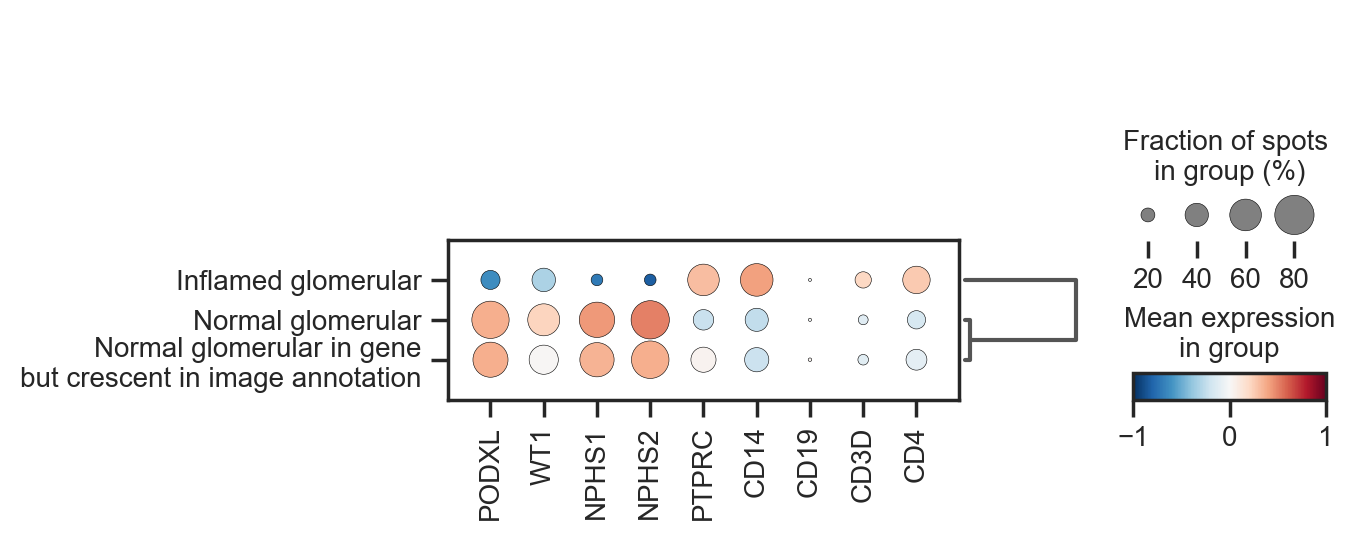

In [28]:
ax = sc.pl.dotplot(tmp, var_names=genes, groupby="cluster_annot_tmp", use_raw=False, vmin=-1, vmax=1, cmap="RdBu_r", 
                   dendrogram=True,
             size_title="Fraction of spots \nin group (%)", show=False)
plt.savefig(os.path.join(figdir, "anca_samples_dotplot_genediff_Normal_glom._Crescent.pdf"), bbox_inches="tight")